In [32]:
import numpy as np
import matplotlib.pyplot as plt
import mat73
import scipy.io as sio


In [33]:
data = mat73.loadmat("/Users/bhoomi/Desktop/CS 736/Assignment3_22B0623_22B0704 2/data/assignmentSegmentBrainGmmEmMrf.mat")
data

{'imageData': array([[0.04380123, 0.0940726 , 0.00727189, ..., 0.03918136, 0.04282553,
         0.01317979],
        [0.078734  , 0.0549603 , 0.01713058, ..., 0.06432267, 0.06783914,
         0.05069654],
        [0.05914955, 0.09139166, 0.01593564, ..., 0.00893907, 0.03878266,
         0.03276115],
        ...,
        [0.02870117, 0.04022088, 0.05524558, ..., 0.03315672, 0.03609456,
         0.04424991],
        [0.04031791, 0.0198631 , 0.01478675, ..., 0.01585535, 0.01632443,
         0.00901131],
        [0.01772919, 0.02725545, 0.04746066, ..., 0.05259117, 0.08544449,
         0.014556  ]]),
 'imageMask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [34]:
imageData = data['imageData']
imageMask = data['imageMask']

In [35]:
image_shape = imageData.shape

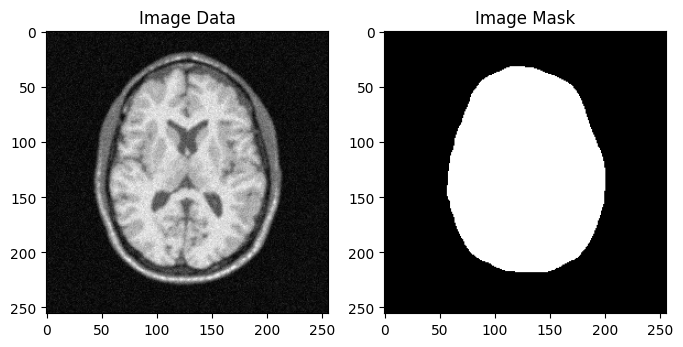

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(imageData, cmap='gray')
ax[0].set_title("Image Data")
ax[1].imshow(imageMask, cmap='gray')
ax[1].set_title("Image Mask")
plt.show()

In [37]:
mask = imageMask > 0
Y = imageData[mask]              
N = len(Y)          

In [38]:
K = 3  
beta = 0.5  
max_iter = 20
tol = 1e-4
epsilon = 1e-6

In [39]:
neighbors_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]


In [40]:
def to_lin(row, col, width):
    return row * width + col

In [41]:
def to_rc(idx, width):
    return divmod(idx, width)

In [42]:
brain_coords = np.where(mask)
brain_linear_idx = [to_lin(r, c, image_shape[1]) for r, c in zip(*brain_coords)]

In [43]:
neighbors_list = [[] for _ in range(N)]
index_map = {}
for i, lin_idx in enumerate(brain_linear_idx):
    index_map[lin_idx] = i

In [44]:
for i, lin_idx in enumerate(brain_linear_idx):
    r, c = to_rc(lin_idx, image_shape[1])
    for dr, dc in neighbors_offsets:
        rr, cc = r + dr, c + dc
        if 0 <= rr < image_shape[0] and 0 <= cc < image_shape[1]:
            if mask[rr, cc]:
                neighbor_lin = to_lin(rr, cc, image_shape[1])
                neighbors_list[i].append(index_map[neighbor_lin])

In [45]:
low_thresh = np.percentile(Y, 33)
high_thresh = np.percentile(Y, 66)

In [46]:
x_init = np.zeros(N, dtype=int) 
for i in range(N):
    if Y[i] < low_thresh:
        x_init[i] = 0  # CSF
    elif Y[i] < high_thresh:
        x_init[i] = 1  # GM
    else:
        x_init[i] = 2  # WM

In [47]:
mu = np.zeros(K)
sigma = np.zeros(K)
for k in range(K):
    vals = Y[x_init == k]
    if len(vals) < 2:
        mu[k] = np.mean(Y)
        sigma[k] = np.std(Y) + epsilon
    else:
        mu[k] = np.mean(vals)
        sigma[k] = np.std(vals) + epsilon

In [48]:
w = np.zeros((N, K))
for i in range(N):
    w[i, x_init[i]] = 1.0

In [49]:
objective_vals = []
log_posterior_labels = []  

def compute_log_posterior_label(x_curr):
    logP = 0.0
    for i in range(N):
        k = x_curr[i]
        diff = (Y[i] - mu[k])**2
        ll = -0.5 * np.log(2*np.pi * sigma[k]**2) - diff/(2*sigma[k]**2)
        logP += ll
    
    for i in range(N):
        xi = x_curr[i]
        for j in neighbors_list[i]:
            if j > i:  
                xj = x_curr[j]
                if xi != xj:
                    logP -= beta
    return logP

In [50]:
for iteration in range(max_iter):

    for i in range(N):
        numerators = np.zeros(K)
        for k in range(K):
            diff = (Y[i] - mu[k])**2
            numerators[k] = np.exp(-diff/(2*sigma[k]**2)) / (sigma[k] + epsilon)
        s = np.sum(numerators) + epsilon
        w[i, :] = numerators / s

    for k in range(K):
        w_k = w[:, k]
        sum_wk = np.sum(w_k)
        if sum_wk < epsilon:
            mu[k] = np.mean(Y)
            sigma[k] = np.std(Y) + epsilon
        else:
            mu[k] = np.sum(w_k * Y) / (sum_wk + epsilon)
            diff2 = (Y - mu[k])**2
            sigma[k] = np.sqrt(np.sum(w_k * diff2) / (sum_wk + epsilon) + epsilon)


    x_old = np.argmax(w, axis=1).copy()  

    logP_before = compute_log_posterior_label(x_old)

    x_new = x_old.copy()
    for i in range(N):
        best_label = x_old[i]
        best_val = -1e15
        for k in range(K):
            diff = (Y[i] - mu[k])**2
            ll = -0.5 * np.log(2*np.pi * sigma[k]**2) - diff/(2*sigma[k]**2)

            prior_val = 0.0
            for j in neighbors_list[i]:
                if x_new[j] != k:
                    prior_val -= beta
            val_k = ll + prior_val
            if val_k > best_val:
                best_val = val_k
                best_label = k
        x_new[i] = best_label

    logP_after = compute_log_posterior_label(x_new)

    if logP_after >= logP_before:
        x_final = x_new
    else:
        x_final = x_old

    w = np.zeros((N, K))
    for i in range(N):
        w[i, x_final[i]] = 1.0

    log_posterior_labels.append((logP_before, logP_after))

    if iteration > 0:
        if abs(logP_after - log_posterior_labels[-2][1]) < tol:
            print(f"Converged at iteration {iteration}")
            break

In [51]:
x_est = np.zeros(mask.shape, dtype=int)
x_est[mask] = x_final

In [52]:
w_est = np.zeros((mask.shape[0], mask.shape[1], K))
count = 0
for (r, c) in zip(*brain_coords):
    w_est[r, c, :] = w[count, :]
    count += 1

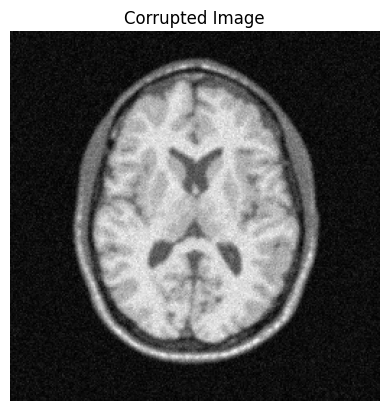

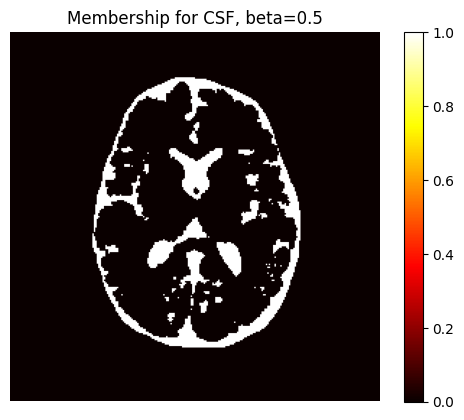

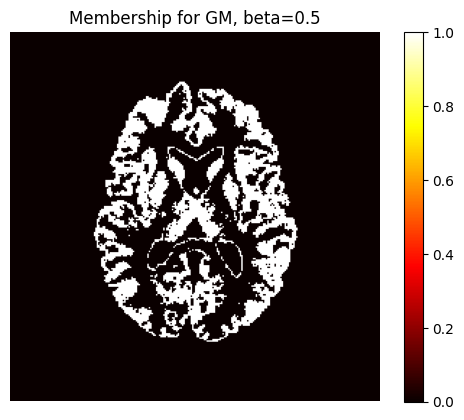

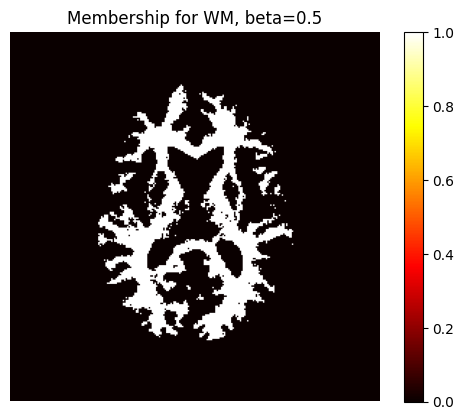

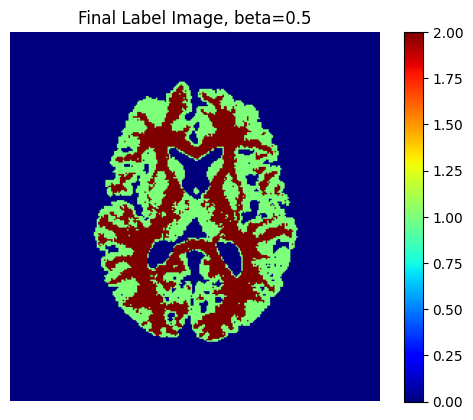

Final class means: [0.37955903 0.53467993 0.63583703]
Final class std devs: [0.13607518 0.03840265 0.03524493]


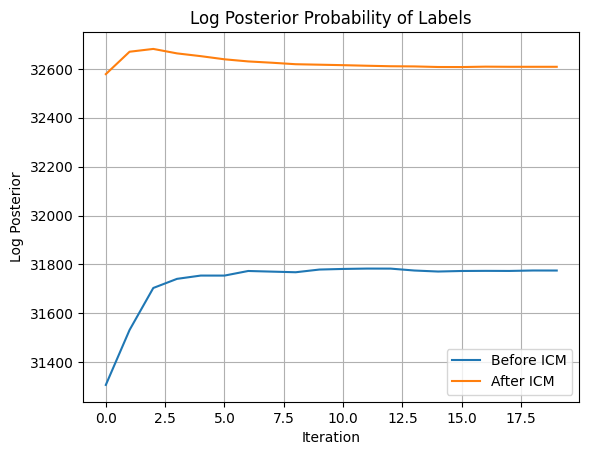

In [53]:
plt.figure()
plt.imshow(imageData, cmap='gray')
plt.title('Corrupted Image')
plt.axis('off')
plt.show()

for k in range(K):
    plt.figure()
    plt.imshow(w_est[..., k], cmap='hot')
    class_name = 'CSF' if k==0 else 'GM' if k==1 else 'WM'
    plt.title(f'Membership for {class_name}, beta={beta}')
    plt.colorbar()
    plt.axis('off')
    plt.show()

plt.figure()
plt.imshow(x_est, cmap='jet')
plt.title(f'Final Label Image, beta={beta}')
plt.colorbar()
plt.axis('off')
plt.show()

print("Final class means:", mu)
print("Final class std devs:", sigma)

before_vals = [v[0] for v in log_posterior_labels]
after_vals = [v[1] for v in log_posterior_labels]

plt.figure()
plt.plot(before_vals, label='Before ICM')
plt.plot(after_vals, label='After ICM')
plt.title('Log Posterior Probability of Labels')
plt.xlabel('Iteration')
plt.ylabel('Log Posterior')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
before_vals[-1], after_vals[-1]

(np.float64(31775.244687697174), np.float64(32608.47414678603))

In [55]:
beta = 0

In [56]:
for iteration in range(max_iter):
    for i in range(N):
        numerators = np.zeros(K)
        for k in range(K):
            diff = (Y[i] - mu[k])**2
            numerators[k] = np.exp(-diff/(2*sigma[k]**2)) / (sigma[k] + epsilon)
        s = np.sum(numerators) + epsilon
        w[i, :] = numerators / s

    for k in range(K):
        w_k = w[:, k]
        sum_wk = np.sum(w_k)
        if sum_wk < epsilon:
            mu[k] = np.mean(Y)
            sigma[k] = np.std(Y) + epsilon
        else:
            mu[k] = np.sum(w_k * Y) / (sum_wk + epsilon)
            diff2 = (Y - mu[k])**2
            sigma[k] = np.sqrt(np.sum(w_k * diff2) / (sum_wk + epsilon) + epsilon)

    x_old = np.argmax(w, axis=1).copy()  

    logP_before = compute_log_posterior_label(x_old)

    x_new = x_old.copy()
    for i in range(N):
        best_label = x_old[i]
        best_val = -1e15
        for k in range(K):
            diff = (Y[i] - mu[k])**2
            ll = -0.5 * np.log(2*np.pi * sigma[k]**2) - diff/(2*sigma[k]**2)
            prior_val = 0.0
            for j in neighbors_list[i]:
                if x_new[j] != k:
                    prior_val -= beta
            val_k = ll + prior_val
            if val_k > best_val:
                best_val = val_k
                best_label = k
        x_new[i] = best_label

    logP_after = compute_log_posterior_label(x_new)

    if logP_after >= logP_before:
        x_final = x_new
    else:
        x_final = x_old

    w = np.zeros((N, K))
    for i in range(N):
        w[i, x_final[i]] = 1.0

    log_posterior_labels.append((logP_before, logP_after))

    if iteration > 0:
        if abs(logP_after - log_posterior_labels[-2][1]) < tol:
            print(f"Converged at iteration {iteration}")
            break

In [60]:
posterior_values = []

for iteration in range(max_iter):
    for i in range(N):
        numerators = np.zeros(K)
        for k in range(K):
            diff = (Y[i] - mu[k])**2
            numerators[k] = np.exp(-diff/(2*sigma[k]**2)) / (sigma[k] + epsilon)
        s = np.sum(numerators) + epsilon
        w[i, :] = numerators / s

    for k in range(K):
        w_k = w[:, k]
        sum_wk = np.sum(w_k)
        if sum_wk < epsilon:
            mu[k] = np.mean(Y)
            sigma[k] = np.std(Y) + epsilon
        else:
            mu[k] = np.sum(w_k * Y) / (sum_wk + epsilon)
            diff2 = (Y - mu[k])**2
            sigma[k] = np.sqrt(np.sum(w_k * diff2) / (sum_wk + epsilon) + epsilon)

    x_old = np.argmax(w, axis=1).copy()  

    logP_before = compute_log_posterior_label(x_old)

    x_new = x_old.copy()
    for i in range(N):
        best_label = x_old[i]
        best_val = -1e15
        for k in range(K):
            diff = (Y[i] - mu[k])**2
            ll = -0.5 * np.log(2*np.pi * sigma[k]**2) - diff/(2*sigma[k]**2)
            prior_val = 0.0
            for j in neighbors_list[i]:
                if x_new[j] != k:
                    prior_val -= beta
            val_k = ll + prior_val
            if val_k > best_val:
                best_val = val_k
                best_label = k
        x_new[i] = best_label

    logP_after = compute_log_posterior_label(x_new)

    if logP_after >= logP_before:
        x_final = x_new
    else:
        x_final = x_old

    w = np.zeros((N, K))
    for i in range(N):
        w[i, x_final[i]] = 1.0

    log_posterior_labels.append((logP_before, logP_after))
    posterior_values.append(logP_after)

    if iteration > 0:
        if abs(logP_after - log_posterior_labels[-2][1]) < tol:
            print(f"Converged at iteration {iteration}")
            break

Converged at iteration 5


In [57]:
x_est = np.zeros(mask.shape, dtype=int)
x_est[mask] = x_final

In [58]:
w_est = np.zeros((mask.shape[0], mask.shape[1], K))
count = 0
for (r, c) in zip(*brain_coords):
    w_est[r, c, :] = w[count, :]
    count += 1

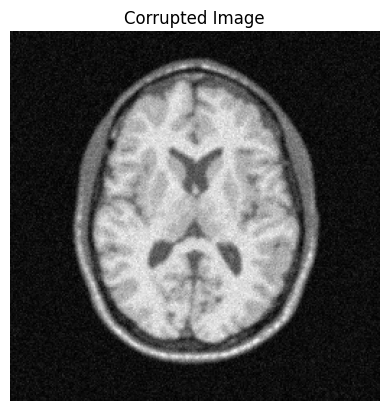

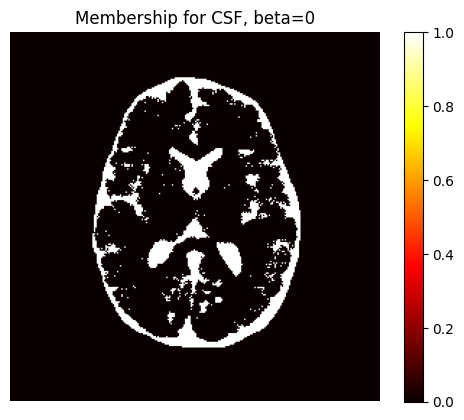

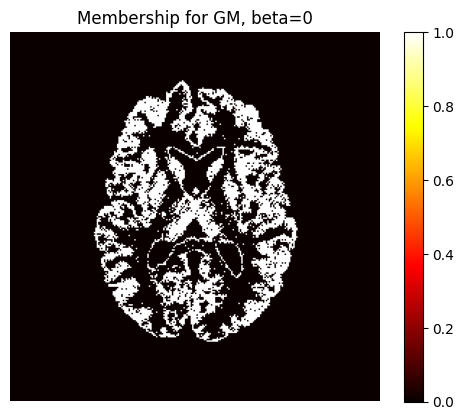

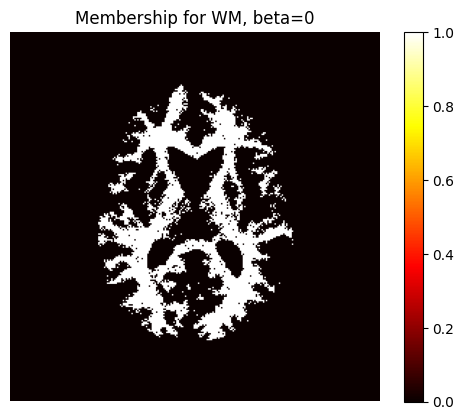

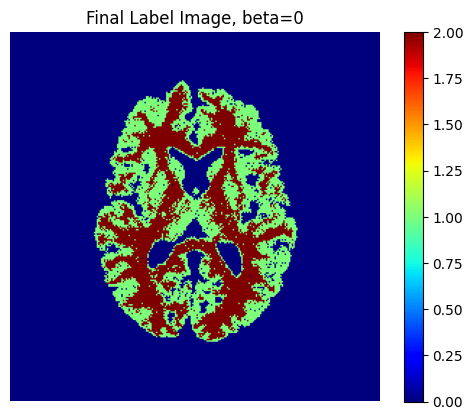

In [59]:
plt.figure()
plt.imshow(imageData, cmap='gray')
plt.title('Corrupted Image')
plt.axis('off')
plt.show()

for k in range(K):
    plt.figure()
    plt.imshow(w_est[..., k], cmap='hot')
    class_name = 'CSF' if k==0 else 'GM' if k==1 else 'WM'
    plt.title(f'Membership for {class_name}, beta={beta}')
    plt.colorbar()
    plt.axis('off')
    plt.show()

plt.figure()
plt.imshow(x_est, cmap='jet')
plt.title(f'Final Label Image, beta={beta}')
plt.colorbar()
plt.axis('off')
plt.show()
